Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import shutil
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/kaggle/input/skin-cancer-detect-melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/kaggle/input/skin-cancer-detect-melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [14]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

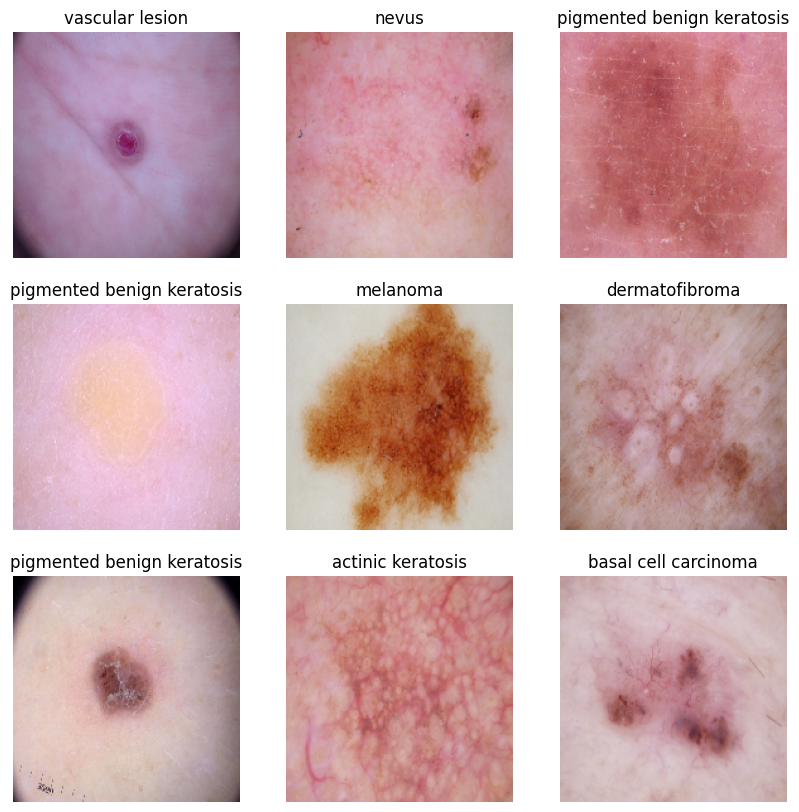

In [15]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### Your code goes here
# CNN model, which can accurately detect 9 classes present in the dataset.
num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(num_classes, activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [18]:
### Todo, choose an appropirate optimiser and loss function

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        102464    
                                                        

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 29s 128ms/step - loss: 2.2509 - accuracy: 0.1819 - val_loss: 2.0478 - val_accuracy: 0.1521
Epoch 2/20
56/56 [==============================] - 4s 65ms/step - loss: 2.0328 - accuracy: 0.1908 - val_loss: 2.0506 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 4s 65ms/step - loss: 2.0492 - accuracy: 0.1992 - val_loss: 2.0434 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 4s 65ms/step - loss: 2.0261 - accuracy: 0.1925 - val_loss: 2.0283 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 4s 65ms/step - loss: 2.0264 - accuracy: 0.1987 - val_loss: 2.0269 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 4s 65ms/step - loss: 2.0215 - accuracy: 0.1992 - val_loss: 2.0308 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 4s 65ms/step - loss: 2.0208 - accuracy: 0.2098 - val_loss: 2.0297 - val_accuracy: 0.2058
Epoch 8/20


### Visualizing training results

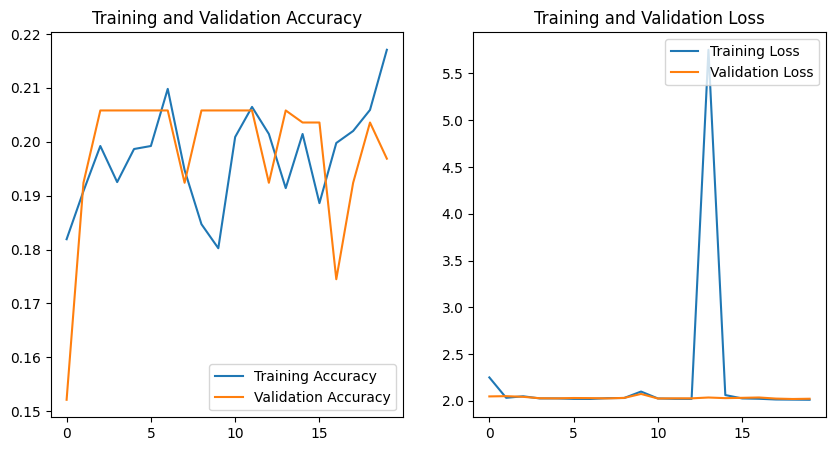

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# Evaluate the model on the test/validation set
evaluation = model.evaluate(test_ds)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

4/4 [==============================] - 5s 200ms/step - loss: 2.2337 - accuracy: 0.1441
Validation Loss: 2.23374080657959
Validation Accuracy: 0.14406779408454895


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

model has 21% training accuracy and 19 % validation accuracy and 14 % test data accuracy

there is very little to no learning hapenning with this model

### Write your findings here

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augument = keras.Sequential([
                     layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                     layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                     layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

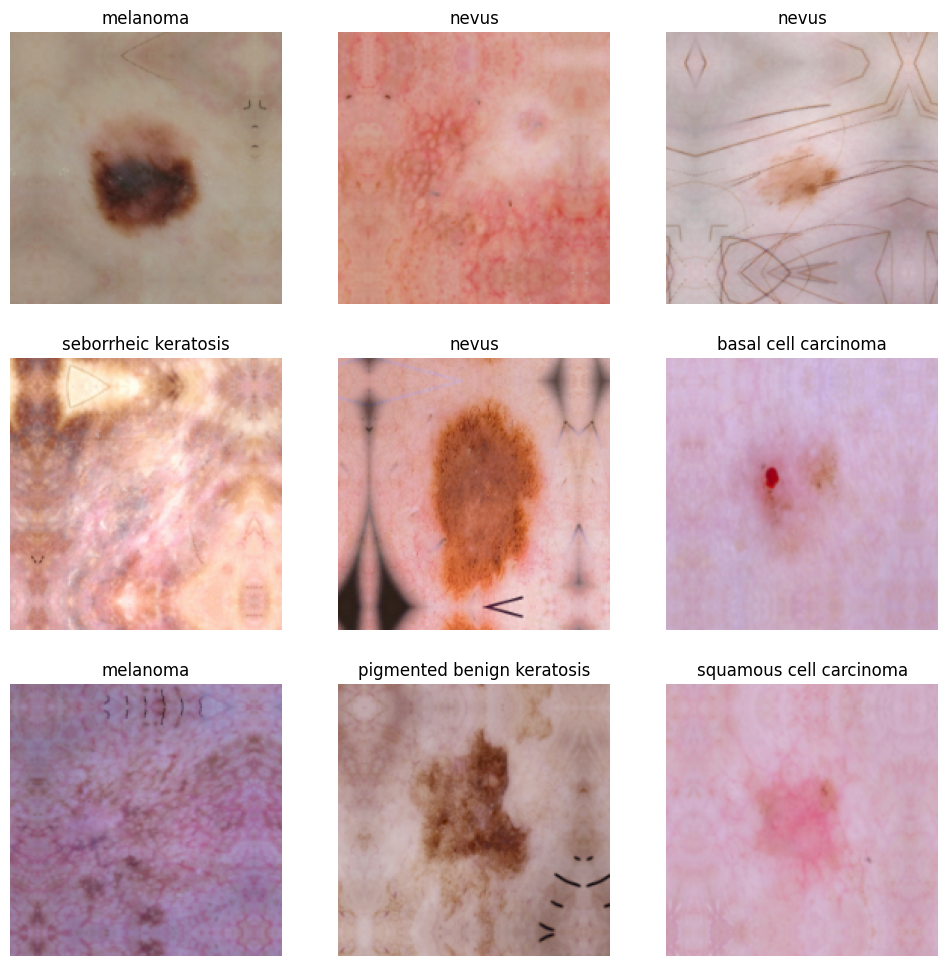

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [27]:
num_classes

9

In [26]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()
model.add(data_augument)
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [28]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                      

### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
)

Epoch 1/20


2023-11-14 14:02:48.740328: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 9s 76ms/step - loss: 224.1770 - accuracy: 0.1468 - val_loss: 188.4765 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 66ms/step - loss: 129.5619 - accuracy: 0.1780 - val_loss: 84.4861 - val_accuracy: 0.1946
Epoch 3/20
56/56 [==============================] - 4s 65ms/step - loss: 58.2873 - accuracy: 0.1864 - val_loss: 43.8447 - val_accuracy: 0.1767
Epoch 4/20
56/56 [==============================] - 4s 66ms/step - loss: 31.1815 - accuracy: 0.1780 - val_loss: 26.4382 - val_accuracy: 0.2148
Epoch 5/20
56/56 [==============================] - 4s 65ms/step - loss: 20.4421 - accuracy: 0.1641 - val_loss: 25.5687 - val_accuracy: 0.2550
Epoch 6/20
56/56 [==============================] - 4s 65ms/step - loss: 22.9088 - accuracy: 0.1663 - val_loss: 11.0372 - val_accuracy: 0.1521
Epoch 7/20
56/56 [==============================] - 4s 66ms/step - loss: 71.8929 - accuracy: 0.1635 - val_loss: 103.6140 - val_accuracy: 0.1946
Epoch 

### Visualizing the results

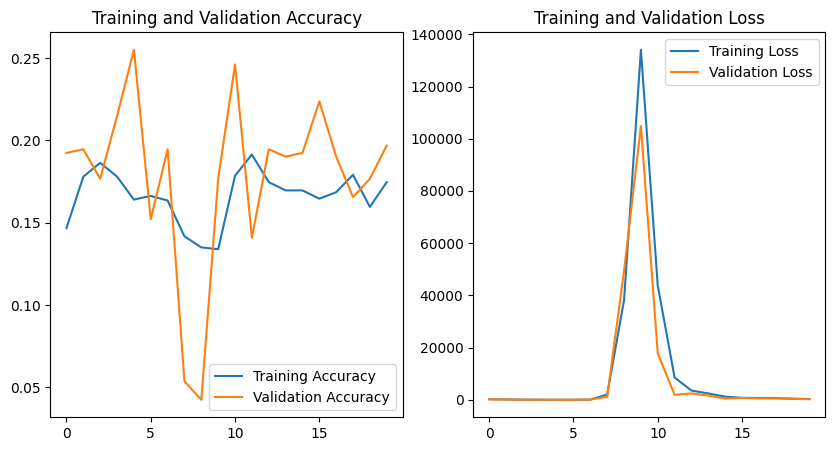

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
# Evaluate the model on the test/validation set
evaluation = model.evaluate(test_ds)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

4/4 [==============================] - 3s 121ms/step - loss: 293.8538 - accuracy: 0.2034
Validation Loss: 293.85382080078125
Validation Accuracy: 0.20338982343673706


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After  adding data agumentation and dropouts the test data accuracy has increased from 14 % to 20 %

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class 'seborrheic keratosis': 58 samples
Class 'squamous cell carcinoma': 142 samples
Class 'pigmented benign keratosis': 370 samples
Class 'nevus': 277 samples
Class 'melanoma': 352 samples
Class 'basal cell carcinoma': 309 samples
Class 'actinic keratosis': 92 samples
Class 'vascular lesion': 115 samples
Class 'dermatofibroma': 77 samples


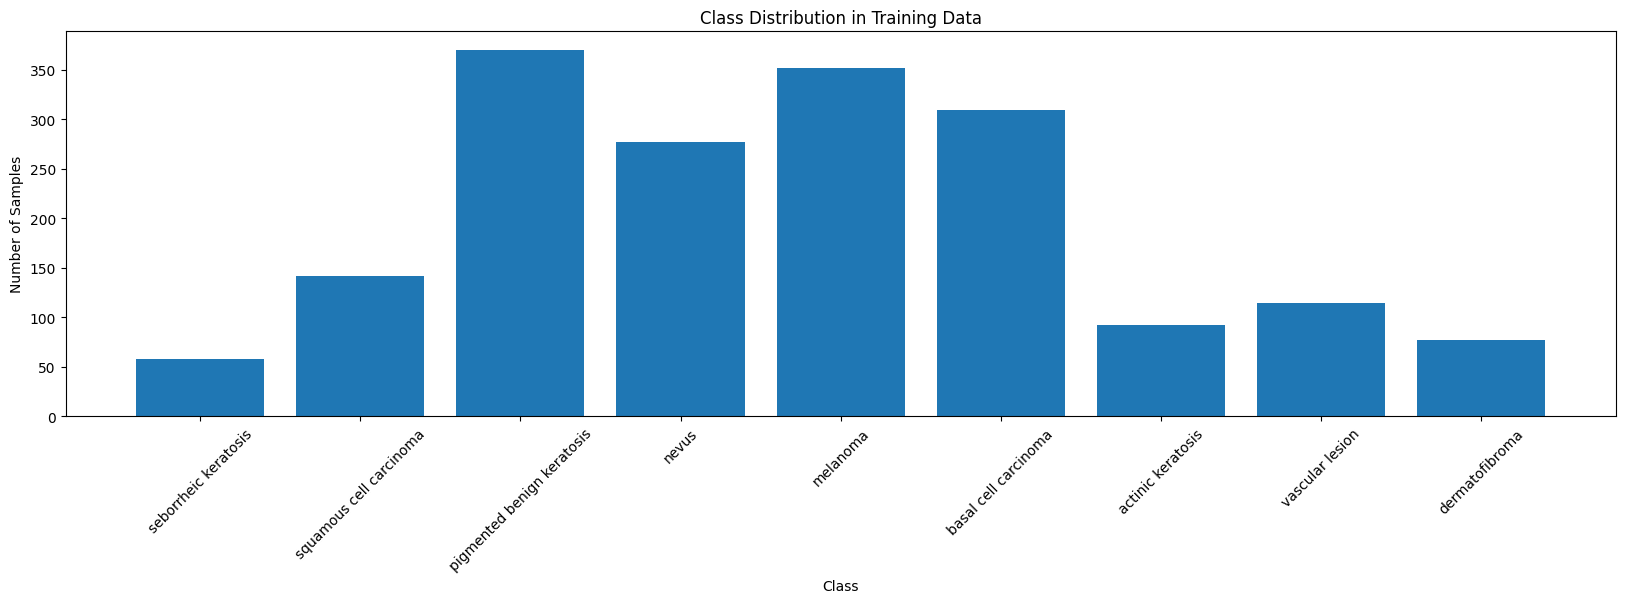

In [33]:
## Your code goes here.

import tensorflow as tf
import numpy as np

class_counts = {}
for images, labels in train_ds:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Print the class distribution
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} samples")


# Optionally, you can visualize the class distribution using a bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?

Class 'seborrheic keratosis': 58 samples

#### - Which classes dominate the data in terms proportionate number of samples?
Class 'pigmented benign keratosis': 370 samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [36]:
path_to_training_dataset=str(data_dir_train)+"/"
output_directory='/kaggle/working/data/'
import Augmentor
for i in class_names[:]:
#     print(output_directory+i)
    p = Augmentor.Pipeline(path_to_training_dataset + i,output_directory=output_directory+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/data/actinic keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F69489EFB80>: 100%|██████████| 1000/1000 [00:13<00:00, 71.75 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/data/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F69200FE380>: 100%|██████████| 1000/1000 [00:12<00:00, 78.93 Samples/s]                 


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/data/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F69488E7370>: 100%|██████████| 1000/1000 [00:12<00:00, 81.34 Samples/s]                 


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/data/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F692001FBB0>: 100%|██████████| 1000/1000 [01:11<00:00, 13.92 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/data/nevus.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F692014D6F0>: 100%|██████████| 1000/1000 [01:07<00:00, 14.84 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/data/pigmented benign keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F688C1BA650>: 100%|██████████| 1000/1000 [00:12<00:00, 79.38 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/data/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F688DCD7970>: 100%|██████████| 1000/1000 [00:31<00:00, 31.67 Samples/s]                 


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/data/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F688E1E3AC0>: 100%|██████████| 1000/1000 [00:12<00:00, 80.29 Samples/s]                 


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/data/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F68E818D000>: 100%|██████████| 1000/1000 [00:13<00:00, 76.61 Samples/s]                 


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
file_pattern = os.path.join(data_dir_train, '*', '*.jpg')

old_path_list = glob(file_pattern)
# old_path_list[:5]
old_lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
# len(old_lesion_list_new)
dataframe_dict_old = dict(zip(old_path_list, old_lesion_list_new))

In [39]:
new_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])
new_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

In [40]:
new_df

,Path,Label
0,/kaggle/input/skin-cancer-detect-melanoma/Skin...,pigmented benign keratosis
1,/kaggle/input/skin-cancer-detect-melanoma/Skin...,pigmented benign keratosis
2,/kaggle/input/skin-cancer-detect-melanoma/Skin...,pigmented benign keratosis
3,/kaggle/input/skin-cancer-detect-melanoma/Skin...,pigmented benign keratosis
4,/kaggle/input/skin-cancer-detect-melanoma/Skin...,pigmented benign keratosis
...,...,...
2234,/kaggle/input/skin-cancer-detect-melanoma/Skin...,nevus
2235,/kaggle/input/skin-cancer-detect-melanoma/Skin...,nevus
2236,/kaggle/input/skin-cancer-detect-melanoma/Skin...,nevus
2237,/kaggle/input/skin-cancer-detect-melanoma/Skin...,nevus


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [41]:
labels = new_df['Label'].values
image_paths = new_df['Path'].values
len(labels),len(image_paths)

(2239, 2239)

In [42]:
labels = labels.tolist()

#### **Todo**: Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [46]:
output_directory

'/kaggle/working/data/'

In [47]:
# data_dir_train="/kaggle/working/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    output_directory,
    seed=123,
    validation_split = 0.2,
    subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 7200 files for training.


#### **Todo:** Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_directory,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


Class 'pigmented benign keratosis': 810 samples
Class 'nevus': 798 samples
Class 'squamous cell carcinoma': 791 samples
Class 'vascular lesion': 813 samples
Class 'melanoma': 801 samples
Class 'basal cell carcinoma': 781 samples
Class 'seborrheic keratosis': 810 samples
Class 'actinic keratosis': 802 samples
Class 'dermatofibroma': 794 samples


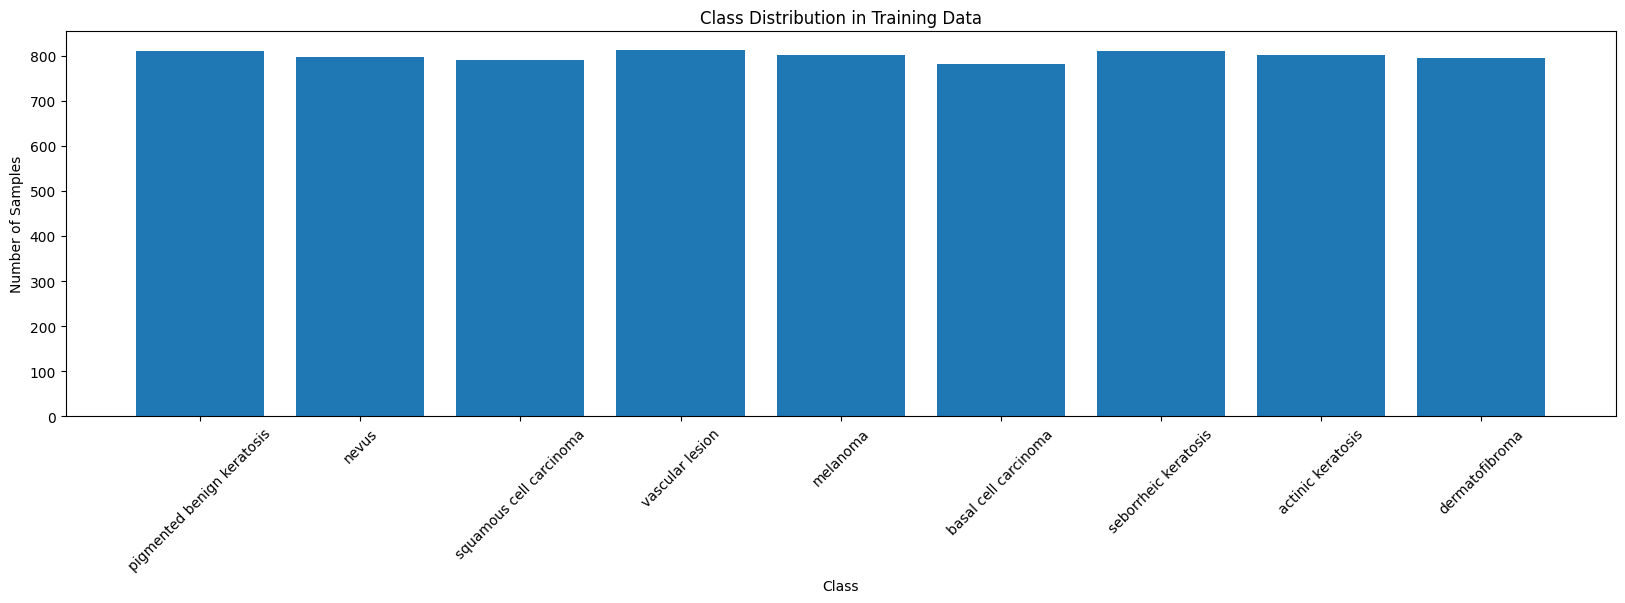

In [49]:
## Your code goes here.

import tensorflow as tf
import numpy as np

class_counts = {}
for images, labels in train_ds:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Print the class distribution
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} samples")


# Optionally, you can visualize the class distribution using a bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

#### **Todo:** Create your model (make sure to include normalization)

In [50]:
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(9))
model.add(Activation('softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 178, 178, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 178, 178, 64)     256       
 hNormalization)                                      

#### **Todo:**  Train your model

In [52]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2023-11-14 14:12:34.478145: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 32s 112ms/step - loss: 12.2865 - accuracy: 0.2557 - val_loss: 4.3360 - val_accuracy: 0.1094
Epoch 2/50
225/225 [==============================] - 25s 110ms/step - loss: 2.7123 - accuracy: 0.3775 - val_loss: 2.6422 - val_accuracy: 0.2339
Epoch 3/50
225/225 [==============================] - 25s 111ms/step - loss: 1.9808 - accuracy: 0.4289 - val_loss: 2.1648 - val_accuracy: 0.3850
Epoch 4/50
225/225 [==============================] - 25s 110ms/step - loss: 1.8110 - accuracy: 0.4447 - val_loss: 6.1944 - val_accuracy: 0.2300
Epoch 5/50
225/225 [==============================] - 25s 110ms/step - loss: 1.8192 - accuracy: 0.4633 - val_loss: 1.9725 - val_accuracy: 0.4389
Epoch 6/50
225/225 [==============================] - 25s 110ms/step - loss: 1.7593 - accuracy: 0.4839 - val_loss: 1.7802 - val_accuracy: 0.4583
Epoch 7/50
225/225 [==============================] - 25s 110ms/step - loss: 1.6371 - accuracy: 0.5058 - val_loss: 1.7040 - val_accuracy: 0.

#### **Todo:**  Visualize the model results

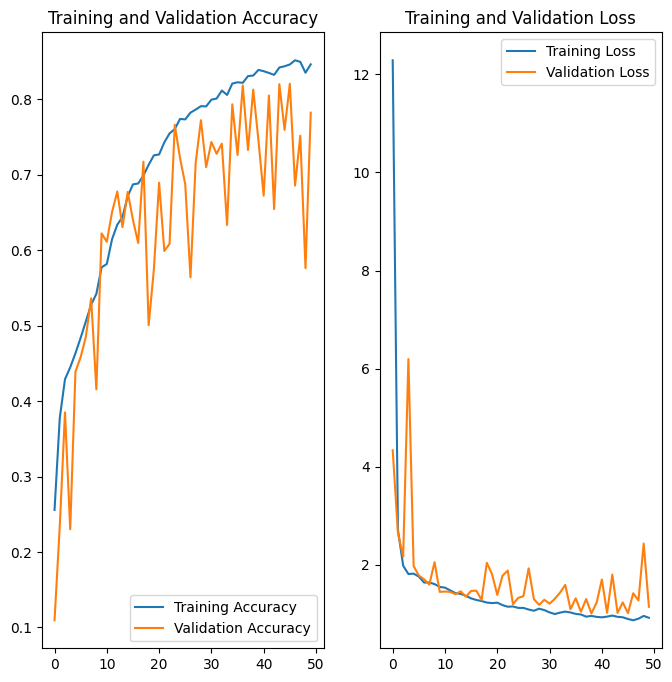

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
# Evaluate the model on the test/validation set
evaluation = model.evaluate(test_ds)
print("test Loss:", evaluation[0])
print("test Accuracy: {:.2f}%".format(evaluation[1] * 100))


4/4 [==============================] - 3s 22ms/step - loss: 3.9559 - accuracy: 0.3983
test Loss: 3.955922842025757
test Accuracy: 39.83%


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We can observer considerable improvement in accuracies after applying data agumentation , dropouts and normalization along with data class balencing 

we can see training accuracy: 84.62 % , val_accuracy: 78.22 % and test accuracy of test Accuracy: 39.83% which is a very big jump

Next steps : 

1. Try deeper and complex networks
2. Hyper parameter tuning
3. Try Diffent prebuit models


In [ ]:
test_ds